In [1]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import torch

from collections import Counter
from dask.multiprocessing import get
from concurrent.futures import ProcessPoolExecutor
from google.cloud import storage
from multiprocessing import Pool, cpu_count
from textblob import TextBlob
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
bucket_name = 'fake-news-data'

comments_df = pd.read_csv(f'gs://{bucket_name}/all_comments.tsv', sep='\t')
train_df = pd.read_csv(f'gs://{bucket_name}/multimodal_train_processed.csv')

## Add average sentiment score of all comments

In [3]:
def calculate_sentiment(text):
    if pd.isnull(text):
        return 0
    blob = TextBlob(text)
    return blob.sentiment.polarity

def calculate_sentiment_batch(texts):
    return [calculate_sentiment(text) for text in texts]

def process_comments_in_batches_parallel(df, batch_size=1000): # Increased batch size
    # Split the dataframe into batches
    batches = [df.iloc[i:i + batch_size].tolist() for i in range(0, len(df), batch_size)]
    # Use a process pool to calculate sentiment in parallel
    with ProcessPoolExecutor() as executor:
        sentiment_scores = list(executor.map(calculate_sentiment_batch, batches))
    # Flatten the list of lists to a single list
    sentiment_scores = [score for batch in sentiment_scores for score in batch]
    return sentiment_scores

In [4]:
# Process in chunks
chunksize = 10 ** 6
chunks = []
num_chunks = len(comments_df) // chunksize + 1

for i in range(num_chunks):
    chunk = comments_df.iloc[i*chunksize:(i+1)*chunksize]
    chunk['sentiment_score'] = process_comments_in_batches_parallel(chunk['body'])
    chunks.append(chunk)

# Concatenate the chunks
comments_df = pd.concat(chunks)

In [5]:
# Compute the average sentiment score for each post
average_sentiment = comments_df.groupby('submission_id')['sentiment_score'].mean().reset_index()

In [6]:
# Rename the column to 'average_sentiment'
average_sentiment.rename(columns={'sentiment_score': 'average_sentiment'}, inplace=True)

In [7]:
# Merge the average sentiment score into the original DataFrame
def merge_sentiment_score(df):
    df = pd.merge(df, average_sentiment, left_on='id', right_on='submission_id', how='left')

    # Handle any missing values
    df['average_sentiment'].fillna(df['average_sentiment'].mean(), inplace=True)
    
    return df

train_df = merge_sentiment_score(train_df)

### Visualize average sentiment by subreddit

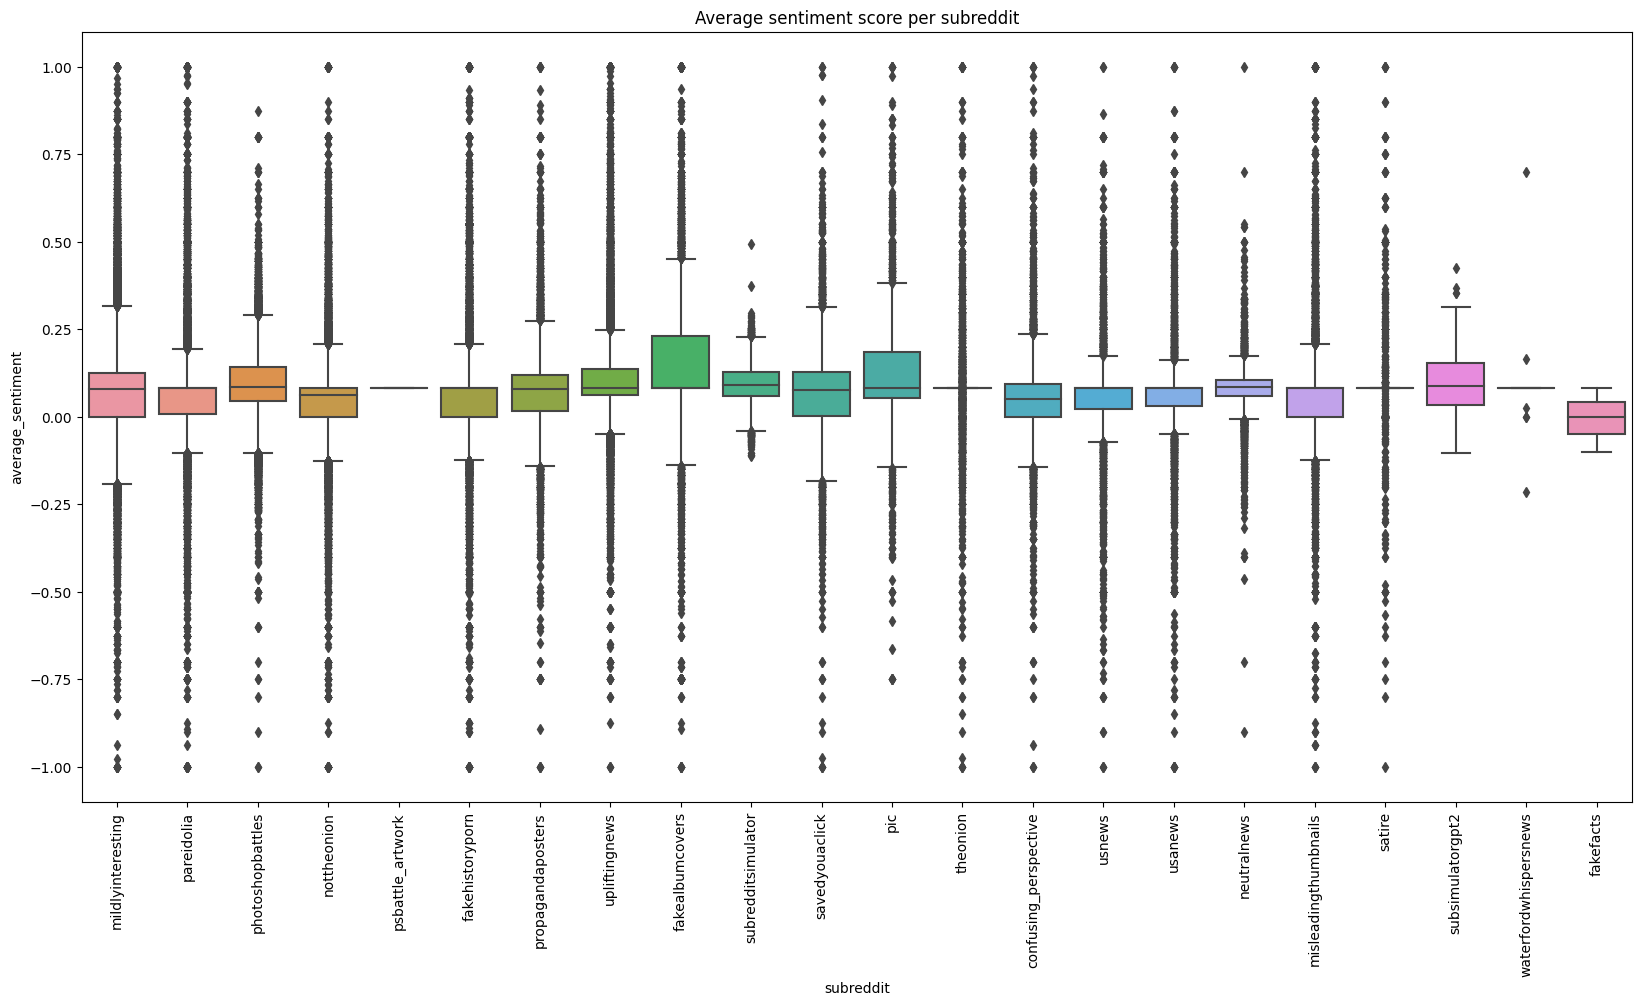

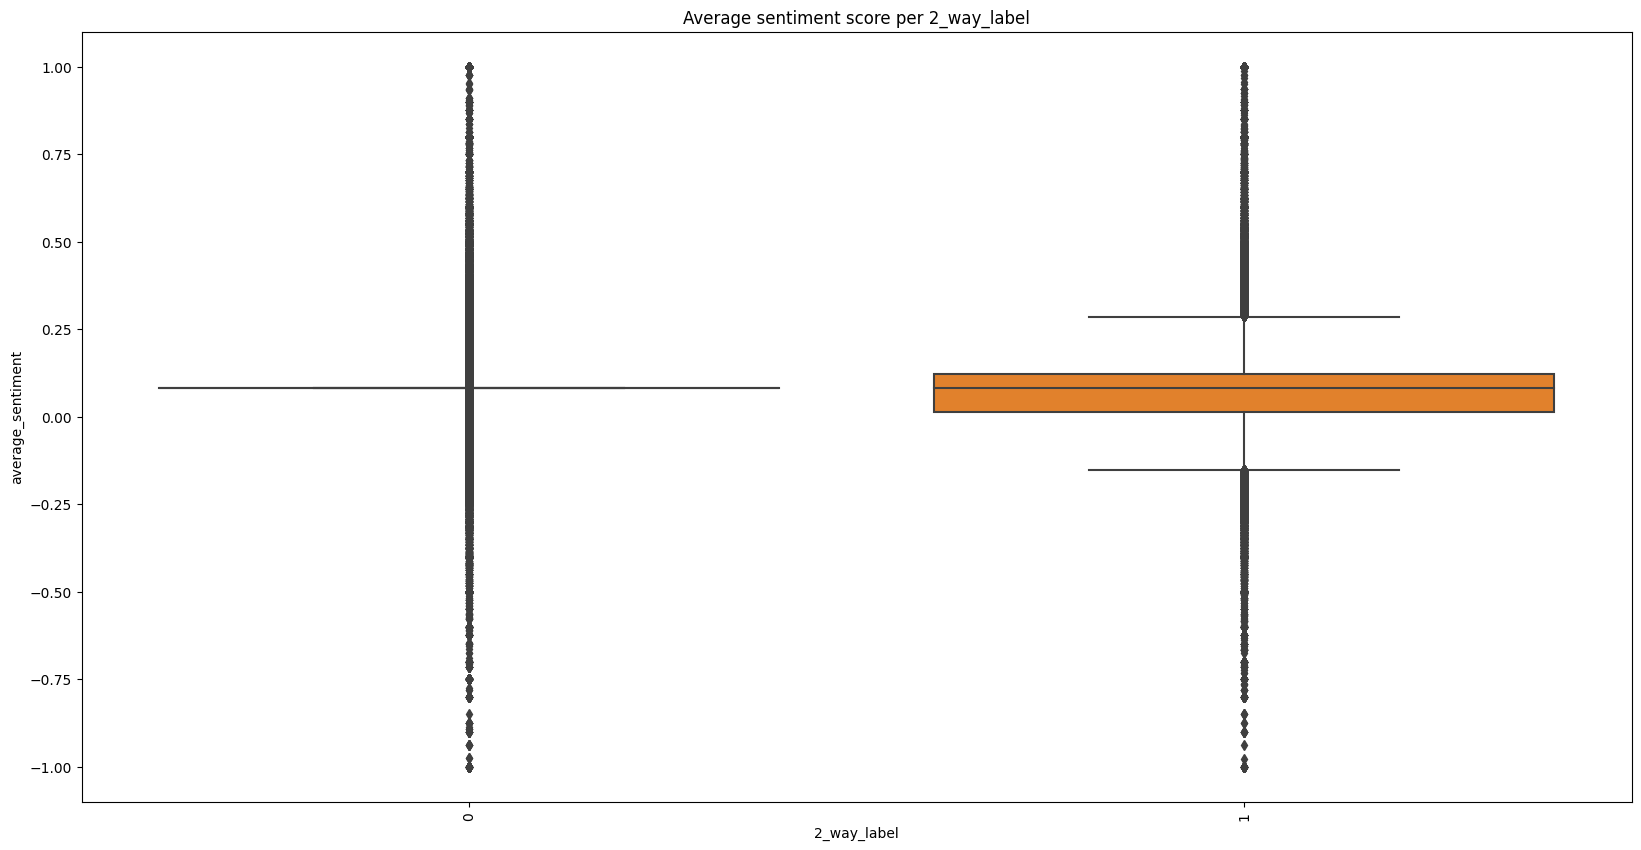

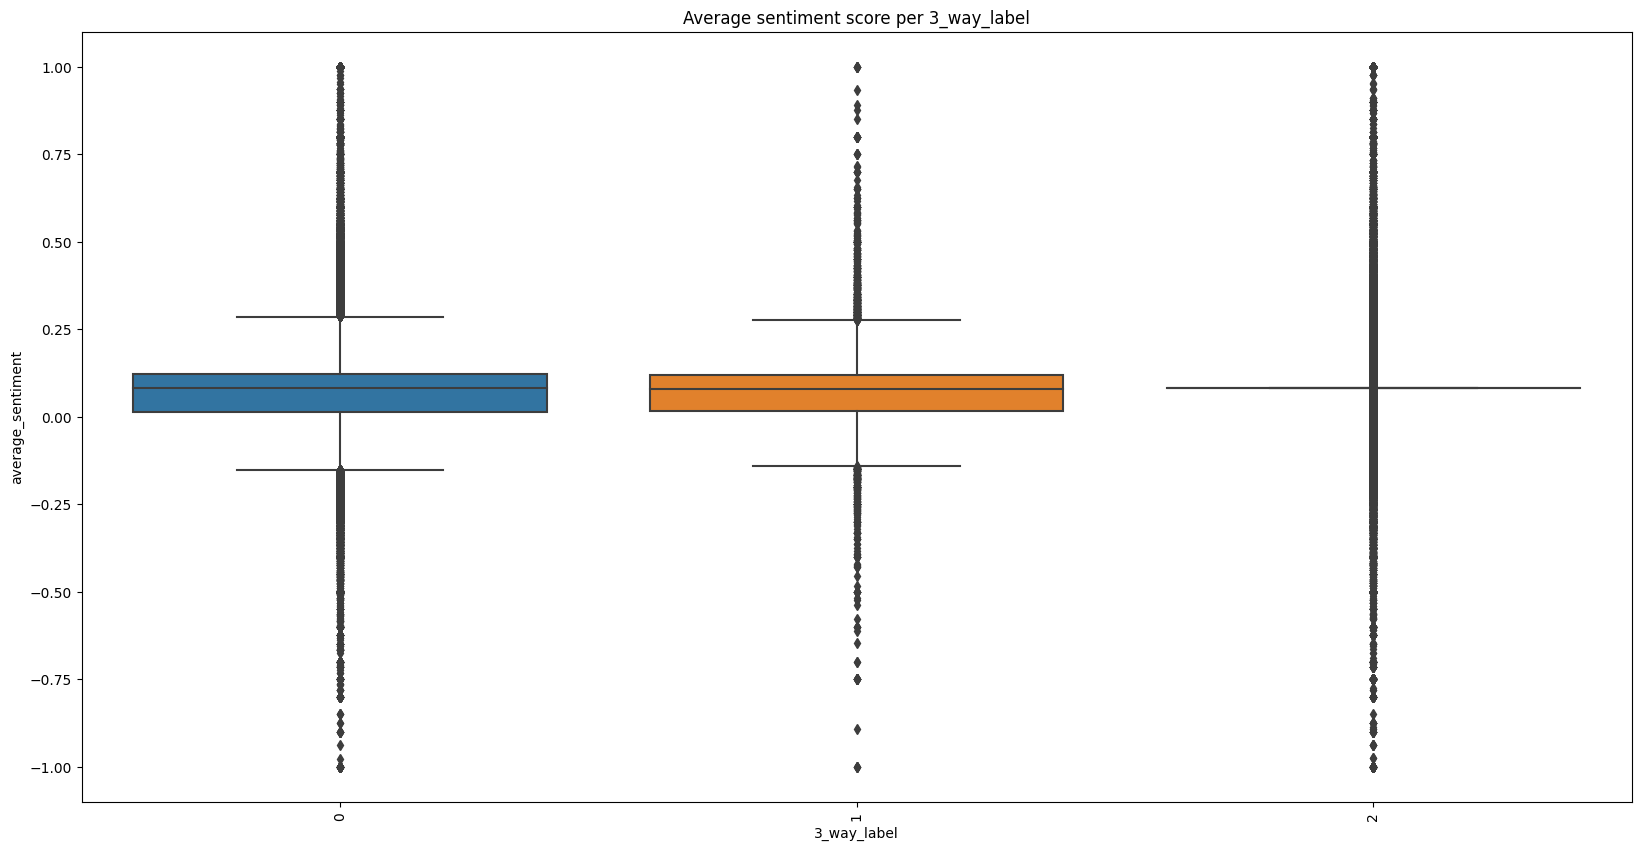

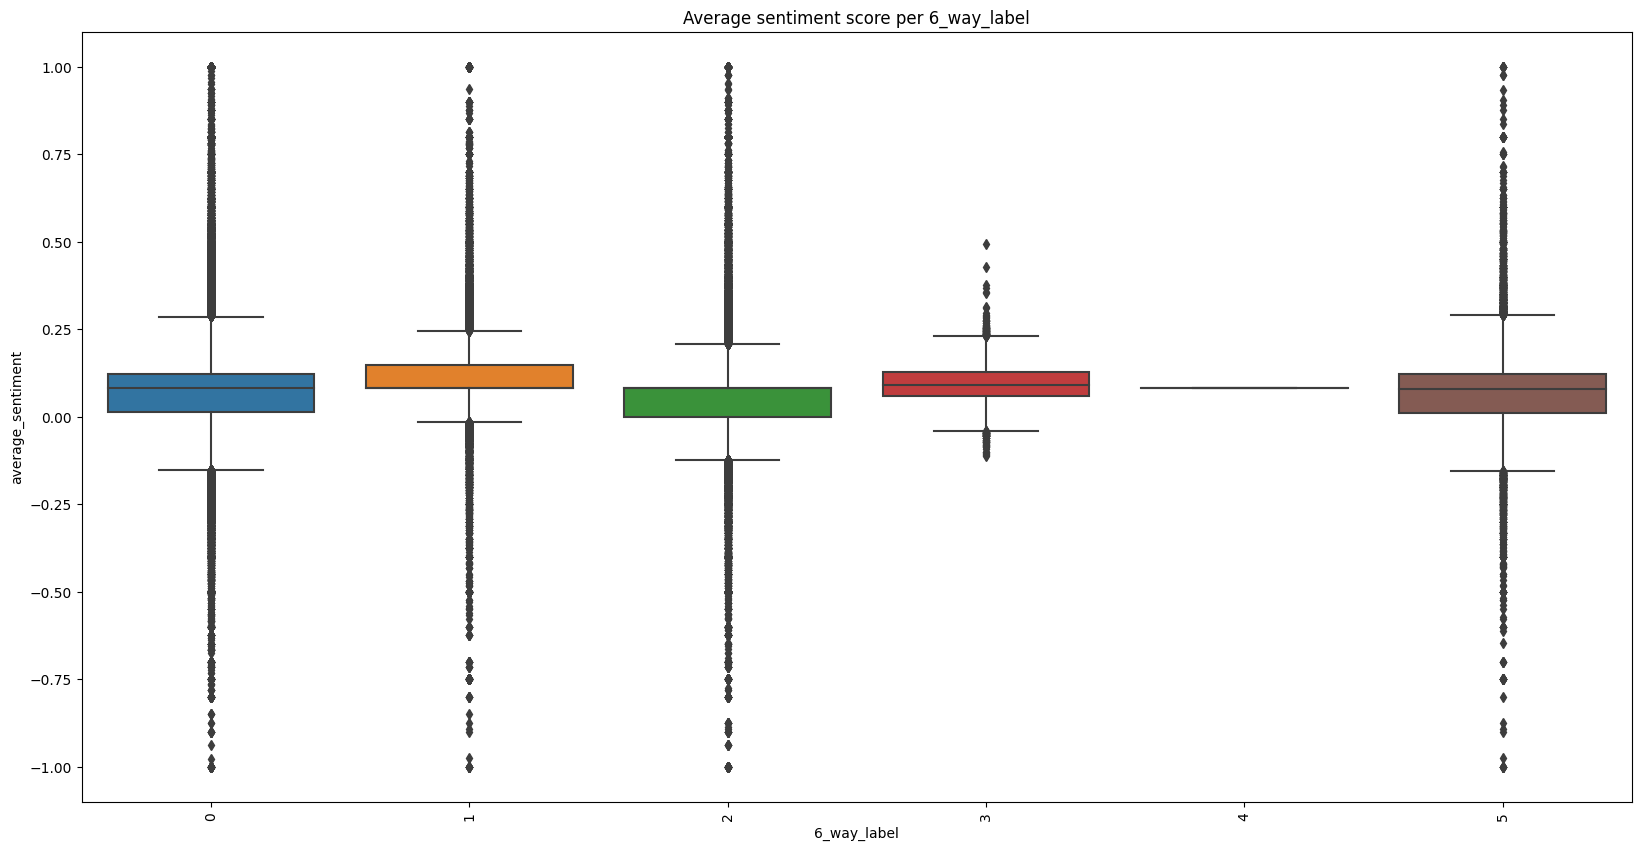

In [8]:
# Function to plot average sentiment scores for each subreddit/label
def plot_sentiment(df, group_column, sentiment_column):
    plt.figure(figsize=(20,10))
    sns.boxplot(x=group_column, y=sentiment_column, data=df)
    plt.title(f'Average sentiment score per {group_column}')
    plt.xticks(rotation=90)
    plt.show()

# For each df, count entities and plot
for group_column in ['subreddit', '2_way_label', '3_way_label', '6_way_label']:
    plot_sentiment(train_df, group_column, 'average_sentiment')

## NER

In [9]:
nlp = spacy.load("en_core_web_sm")  # Loading English tokenizer, tagger, parser, NER and word vectors

def get_entities(text):
    if pd.isnull(text):  # if text is NaN return empty list
        return []
    doc = nlp(text)
    return [ent.label_ for ent in doc.ents]

In [10]:
def parallelize_series(series, func, n_cores=8):
    pool = Pool(n_cores)
    df_split = np.array_split(series, n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [11]:
# apply a function on a DataFrame's column
def apply_on_series(df_series):
    return df_series.apply(get_entities)

In [12]:
# process dataframe
train_df['title_entities'] = parallelize_series(train_df['clean_title'], apply_on_series)

### Sample the df before getting entities for comments

In [13]:
sample_df = train_df.sample(frac=0.1, random_state=42)

In [14]:
# Prune the comments_df to only contain comments for the ids in sample_df
sample_ids = sample_df['id']  # Assuming 'id' is the column in train_df that links to the comments
comments_sample_df = comments_df[comments_df['id'].isin(sample_ids)]

In [15]:
# Apply the get_entities function on the sampled comments_df
def apply_on_dataframe(df):
    df['comment_entities'] = df['body'].apply(get_entities)
    return df

In [17]:
dask_df = dd.from_pandas(comments_sample_df, npartitions=8)  # Adjust npartitions according to your CPU cores

# Apply the function in parallel
comments_sample_df = dask_df.map_partitions(apply_on_dataframe).compute(scheduler='multiprocessing')

In [18]:
# First, convert lists of entities to strings
comments_sample_df['comment_entities_str'] = comments_sample_df['comment_entities'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')

# Now, group by submission_id and join entity strings
grouped_comment_entities = comments_sample_df.groupby('submission_id')['comment_entities_str'].apply(', '.join).reset_index()

# Merge entities with original DataFrames
train_df = pd.merge(sample_df, grouped_comment_entities, how='left', left_on='id', right_on='submission_id')
train_df.drop(columns='submission_id', inplace=True)

### Visualize entities

In [19]:
def visualize_most_common(series, title):
    plt.figure(figsize=(15,6))
    all_entities = [ent for sublist in series for ent in sublist]
    counter = Counter(all_entities)
    most_common_entities = counter.most_common(10)
    plt.bar([x[0] for x in most_common_entities], [x[1] for x in most_common_entities])
    plt.title(title)
    plt.show()

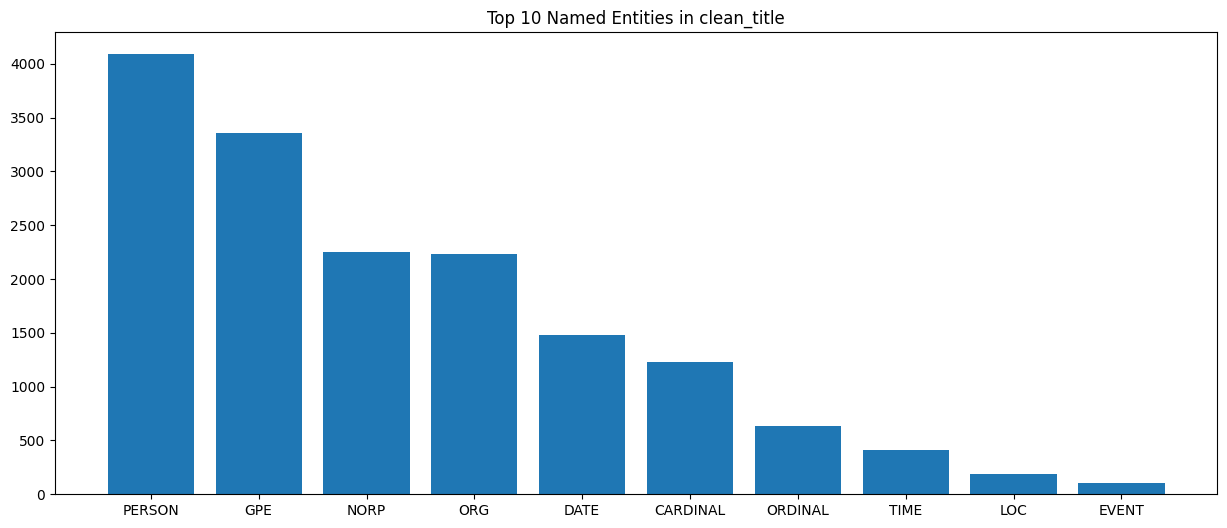

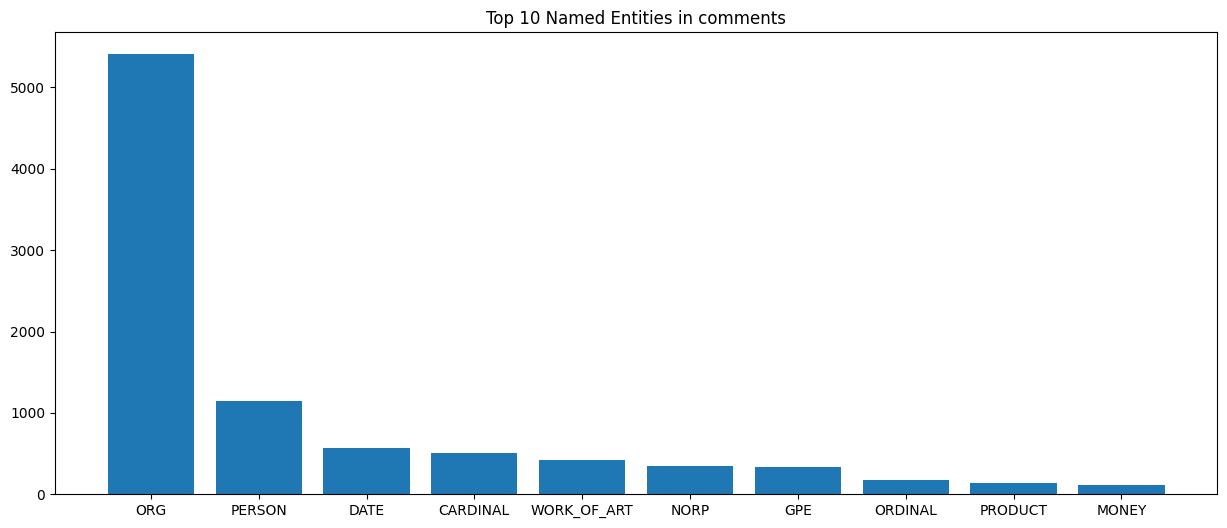

In [20]:
visualize_most_common(sample_df['title_entities'], 'Top 10 Named Entities in clean_title')
visualize_most_common(comments_sample_df['comment_entities'], 'Top 10 Named Entities in comments')

In [21]:
# Function to count entities in each subreddit/label
def count_entities(df, group_column, entities_column):
    entities_grouped = df.groupby(group_column)[entities_column].sum()
    entities_count = entities_grouped.apply(Counter)
    return entities_count

# Function to plot top N entities for each subreddit/label
def plot_top_entities(entities_count, title, N=10):
    plt.figure(figsize=(20,10))
    
    for group, counter in entities_count.items():
        most_common = counter.most_common(N)
        plt.bar([x[0] for x in most_common], [x[1] for x in most_common], label=group)
        
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

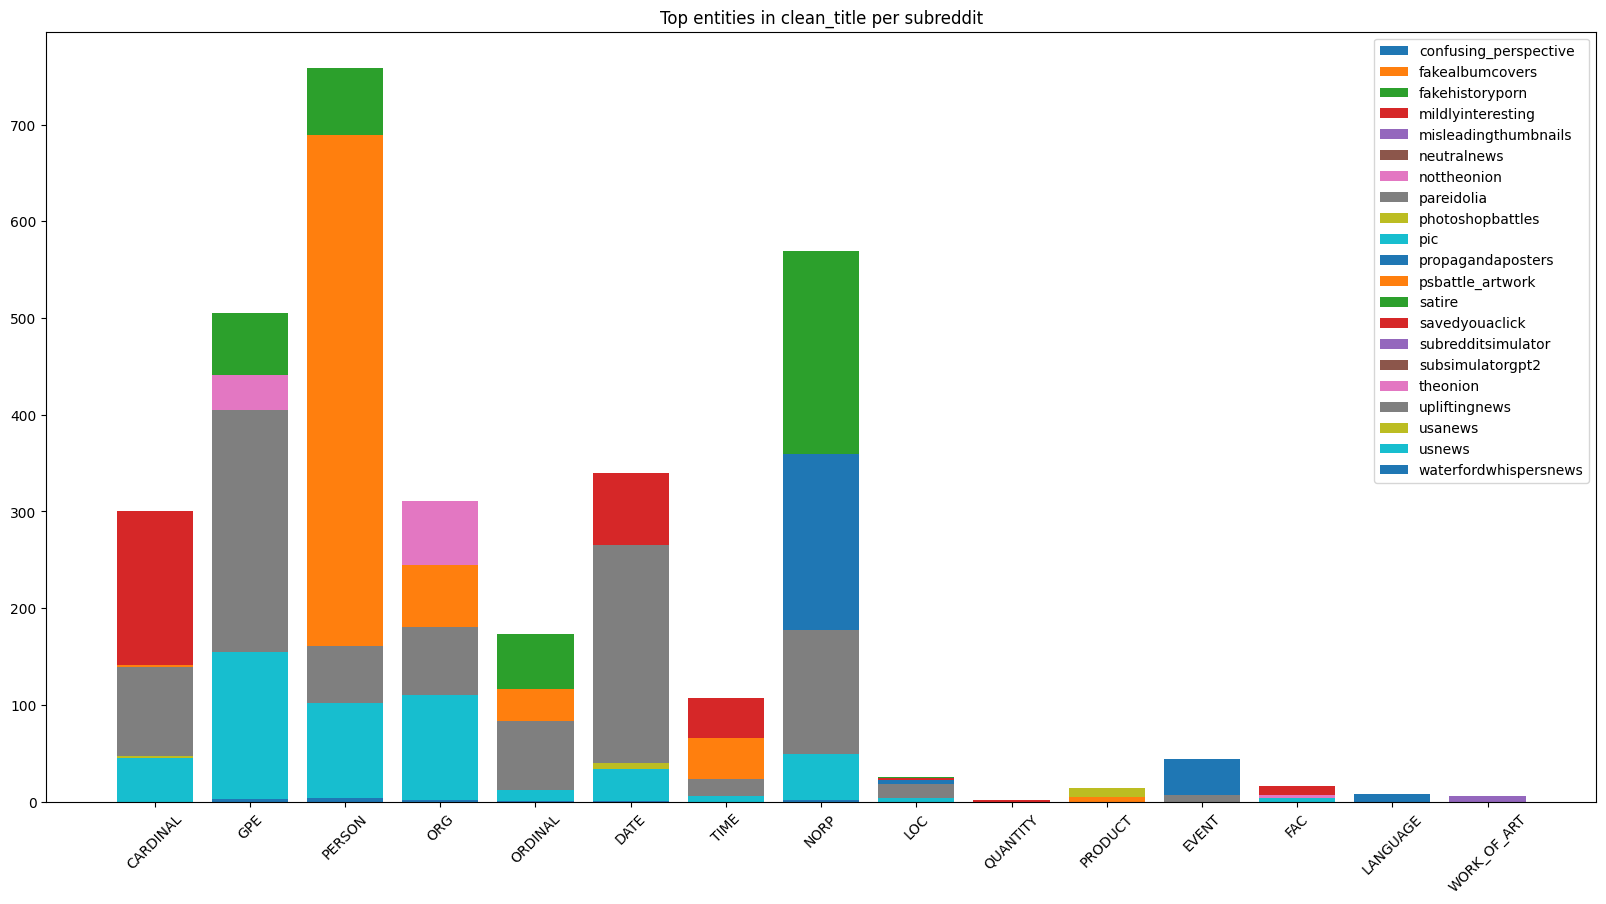

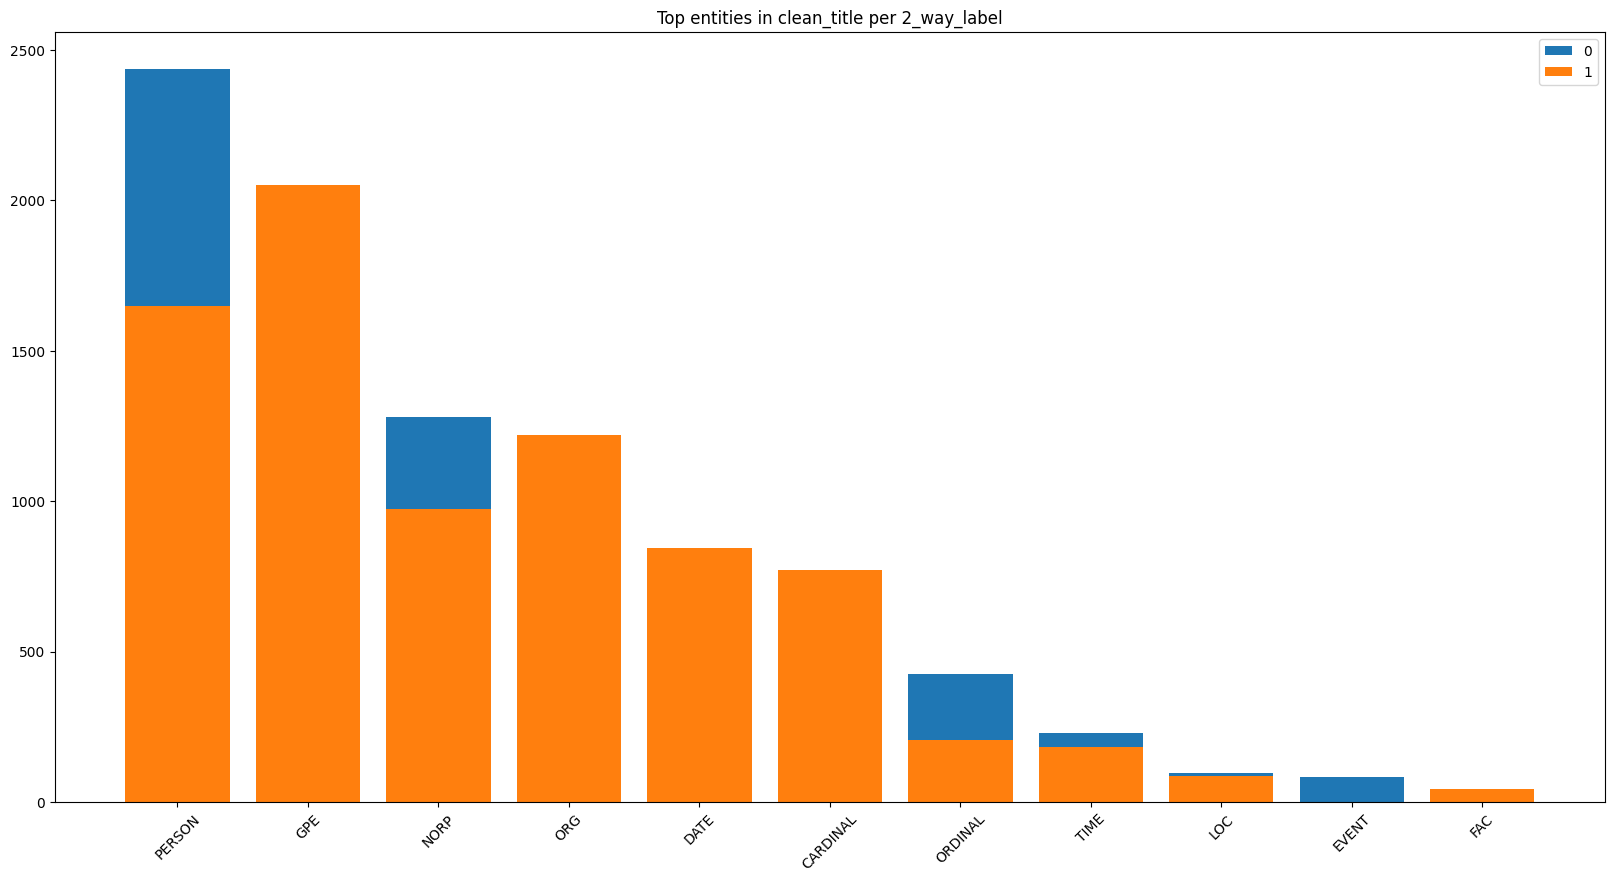

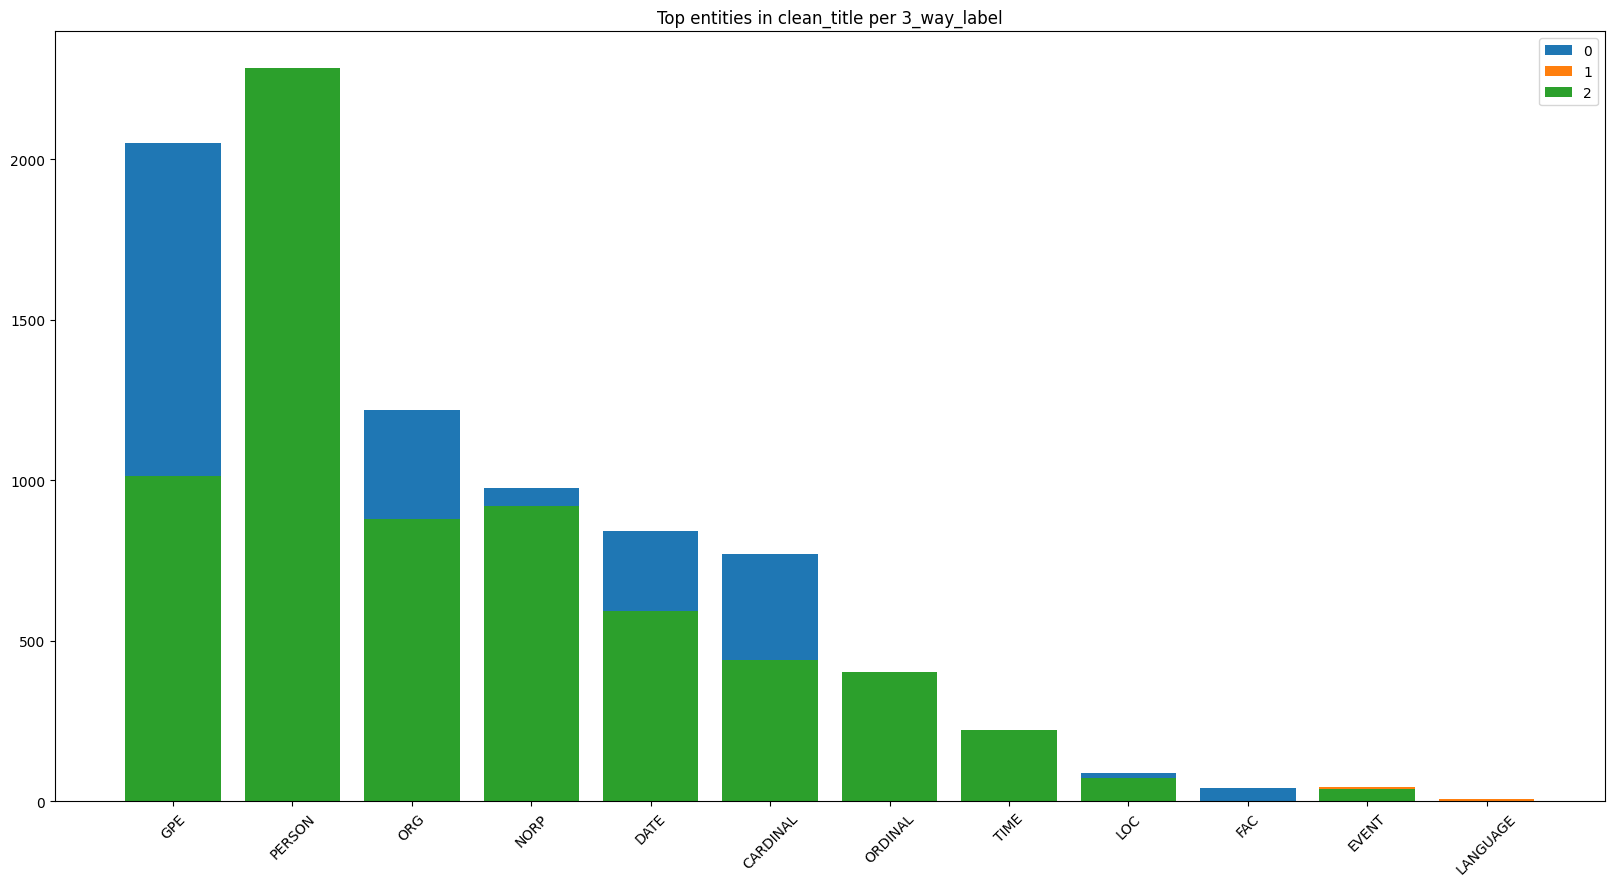

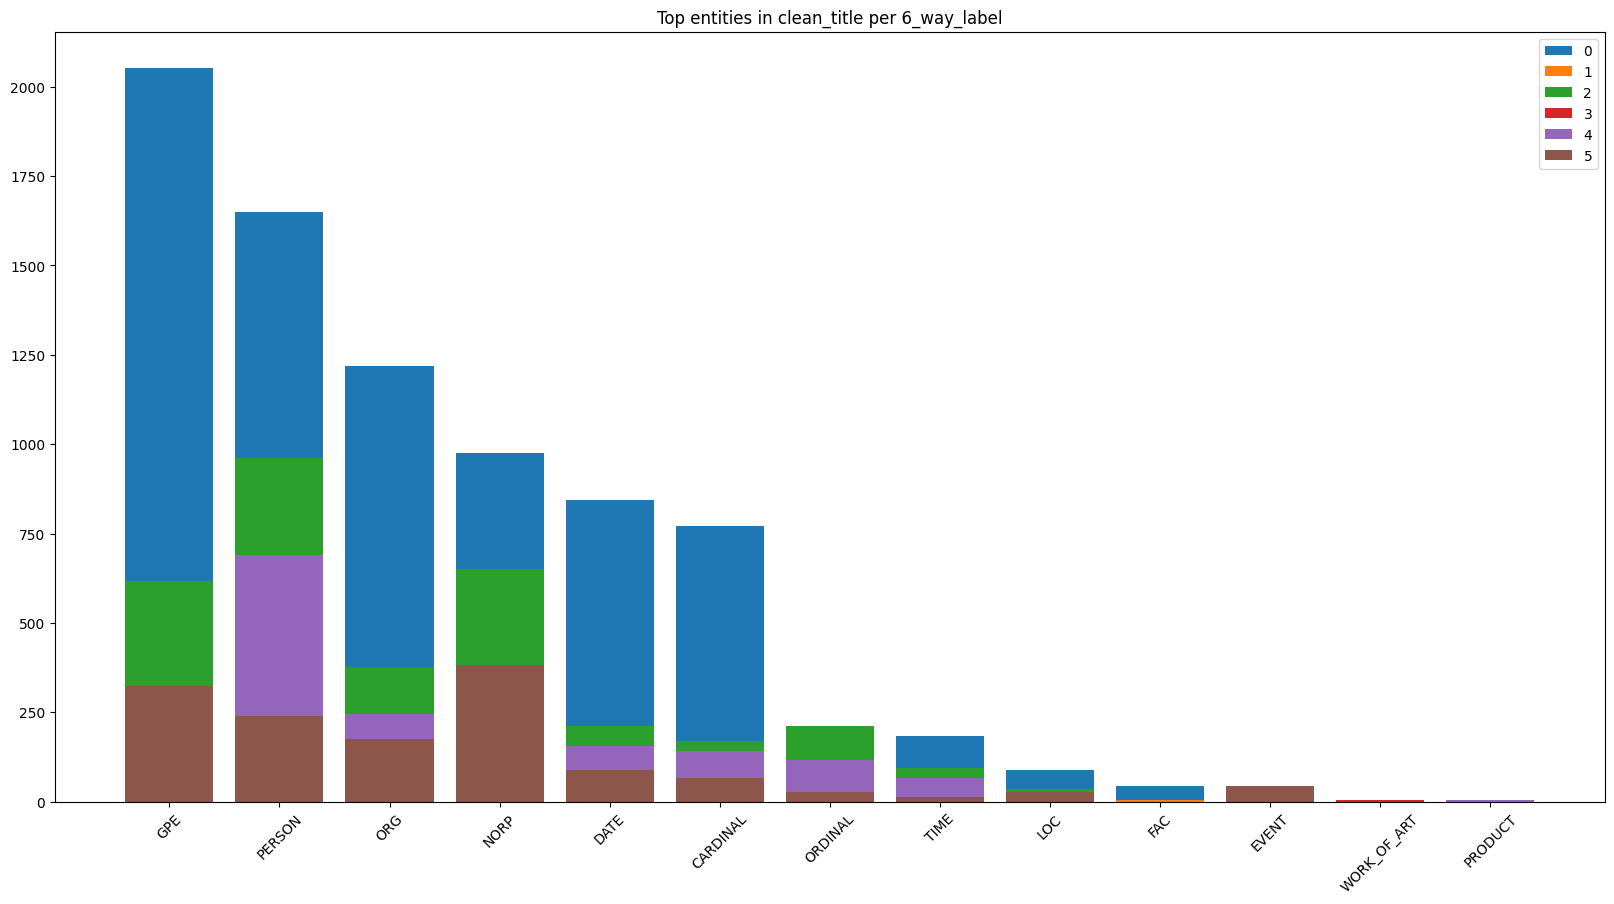

In [22]:
# Count entities and plot
for group_column in ['subreddit', '2_way_label', '3_way_label', '6_way_label']:
    entities_count = count_entities(sample_df, group_column, 'title_entities')
    plot_top_entities(entities_count, f'Top entities in clean_title per {group_column}')

## Upload dfs to GCS

In [23]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )

# save the dataframes to CSVs
sample_df.to_csv('sample_df.csv', index=False)
comments_sample_df.to_csv('comments_sample_df.csv', index=False)

# upload the CSVs to GCS
upload_blob('fake-news-data', 'sample_df.csv', 'sample_df.csv')
upload_blob('fake-news-data', 'comments_sample_df.csv', 'comments_sample_df.csv')

File sample_df.csv uploaded to sample_df.csv.
File comments_sample_df.csv uploaded to comments_sample_df.csv.
